# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [1]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)
data

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,201152,Thaddeus Young,Raptors,Forward,203,107,USA,1988-06-21,14,12,1066.0,29.5,12.9,5.9,1.8,1.4,0.4,2022-03-06,14190000,"33 years, 8 months, 23 days"
456,1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,3,5,262.0,33.4,25.0,3.9,9.0,0.9,0.2,2022-03-07,8326471,"23 years, 5 months, 25 days"
457,1630209,Omer Yurtseven,Heat,Center,211,125,Turkey,1998-06-19,0,Undrafted,45.0,13.7,6.0,5.7,1.0,0.3,0.4,2022-03-07,1489065,"23 years, 8 months, 25 days"
458,203469,Cody Zeller,Hornets,Forward,211,109,USA,1992-10-05,9,4,494.0,22.2,8.5,6.0,1.4,0.6,0.6,NaN,2389641,"29 years, 5 months, 11 days"


Let's have another look at our previously generated dataset. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,classification_report,f1_score,precision_score,recall_score
from sklearn.metrics import plot_confusion_matrix,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import SGDRegressor,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

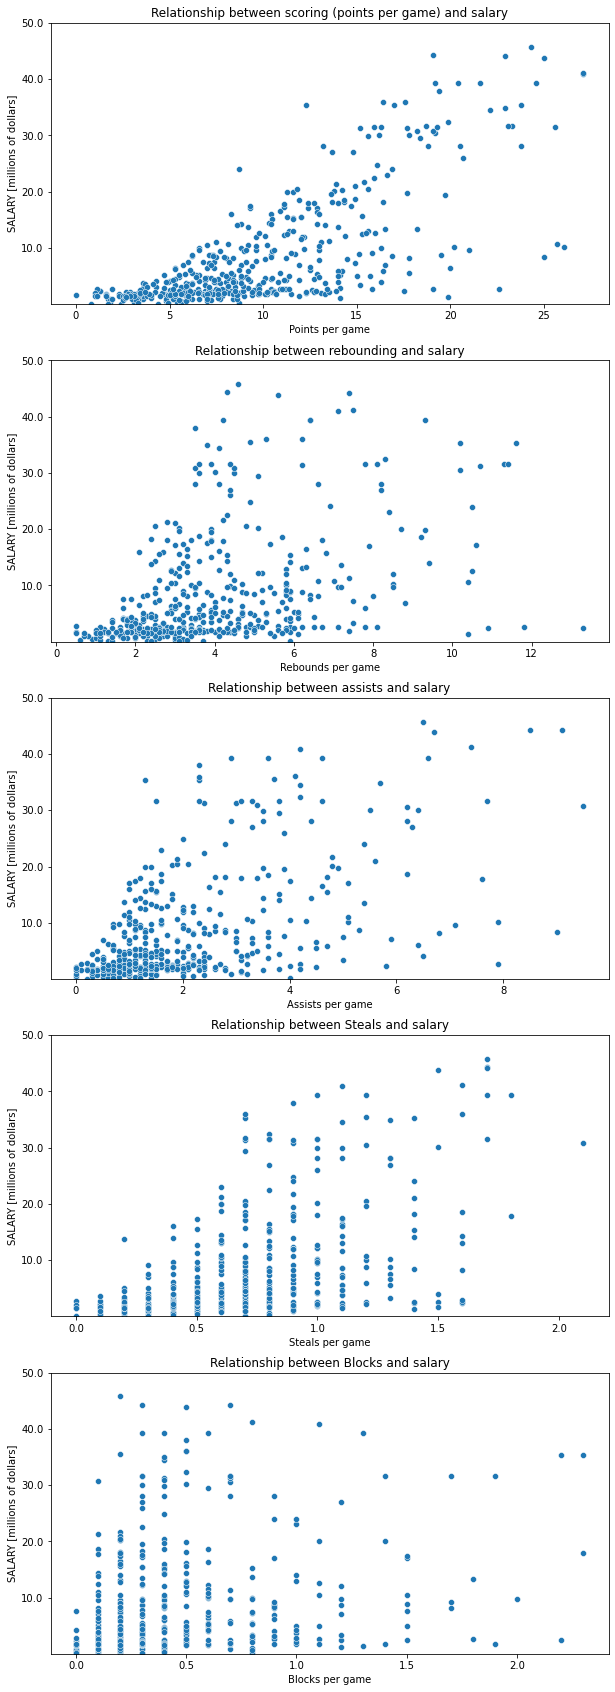

In [3]:
plt.rcParams['figure.figsize'] = [10, 30]
plt.subplot(5, 1, 1)
graph=sns.scatterplot(x='PTS', y='Salary',data=data)
plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylim(bottom=1)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Points per game')
plt.title("Relationship between scoring (points per game) and salary")

plt.subplot(5, 1, 2)
graph=sns.scatterplot(x='REB', y='Salary',data=data)
plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylim(bottom=1)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Rebounds per game')
plt.title("Relationship between rebounding and salary")

plt.subplot(5, 1, 3)
graph=sns.scatterplot(x='AST', y='Salary',data=data)
plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylim(bottom=1)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Assists per game')
plt.title("Relationship between assists and salary")

plt.subplot(5, 1, 4)
graph=sns.scatterplot(x='STL', y='Salary',data=data)
plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylim(bottom=1)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Steals per game')
plt.title("Relationship between Steals and salary")

plt.subplot(5, 1, 5)
graph=sns.scatterplot(x='BLK', y='Salary',data=data)
plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylim(bottom=1)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Blocks per game')
plt.title("Relationship between Blocks and salary")

plt.show()

1.2. What can we say about these distributions?

We can say that if we had to choose one feature to predict salary the best one would be points per game. The others have a correlation with the salary but it's not so marked.

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [4]:
X= data.drop(labels='Salary',axis=1)
y= data.Salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [5]:
class BaselineModel():
    """A baseline model that always returns the same value, the mean of the players salary in the train data"""
    def __init__(self):
        self.mean_salary = None
        '''
        Initialize the variable in a null value.
        '''
    
    def fit(self, y_train):
        """
        Fit the training data. 
        
        Parameters
        ----------
        y_train: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing salary information
        """
        self.mean_salary=round(y_train.mean(),2)
    
    def predict(self, X):
        """
        Predict salaries 
        
        Parameters
        ----------
        X: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the 
            
        Returns
        -------
        np.ndarray
            a numpy array of the same length as X, with all elements equal to the mean salary calculated in fit()
        """
        size=len(X)
        return np.array([self.mean_salary]*size)

In [6]:
first_model=BaselineModel()
first_model.fit(y_train)
y_predict_base_model=first_model.predict(X_test)

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [7]:
baseline_mae=round(mean_absolute_error(y_test,y_predict_base_model))
print('Mean absolute error of Baseline Model:',baseline_mae)

Mean absolute error of Baseline Model: 6905402


### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

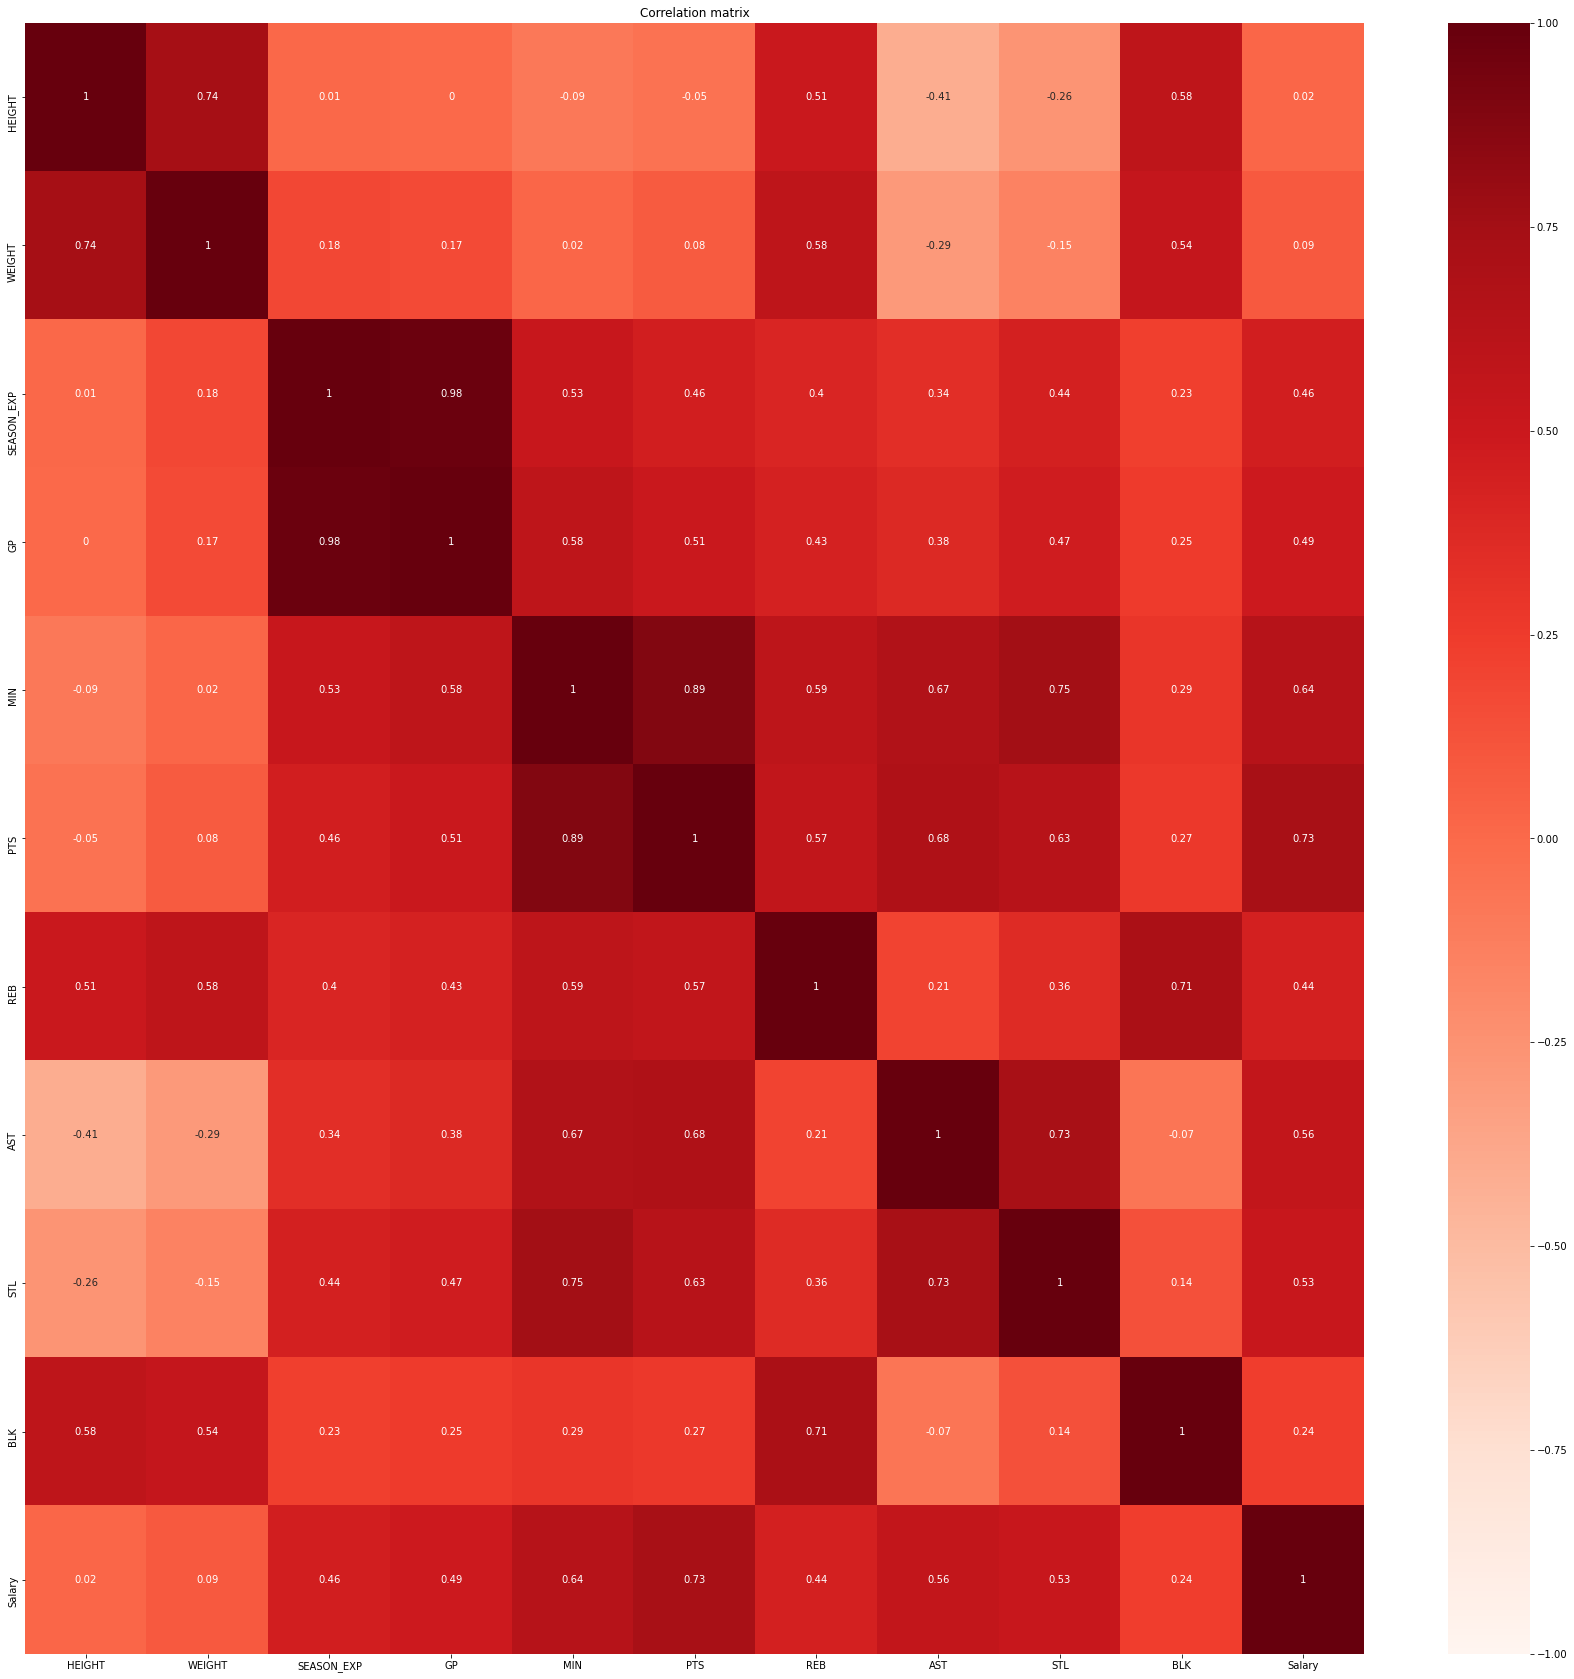

In [8]:
corr_table = data.set_index('PERSON_ID').corr(method='pearson').round(2)
plt.figure(figsize = (30, 30))
sns.heatmap(corr_table, annot=True, cmap=plt.cm.Reds,vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

I decide to select PTS column because has the highest correlation with salary.

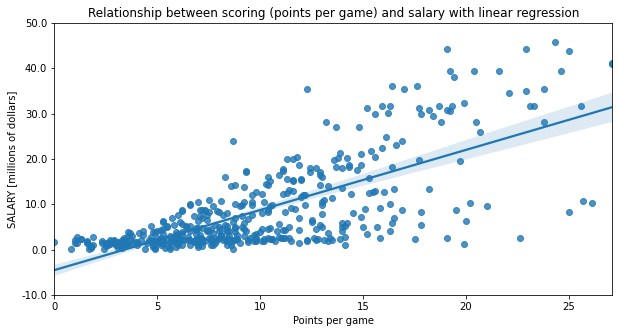

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]
graph=sns.regplot(x='PTS', y='Salary',data=data)
plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Points per game')
plt.title("Relationship between scoring (points per game) and salary with linear regression")
plt.show()

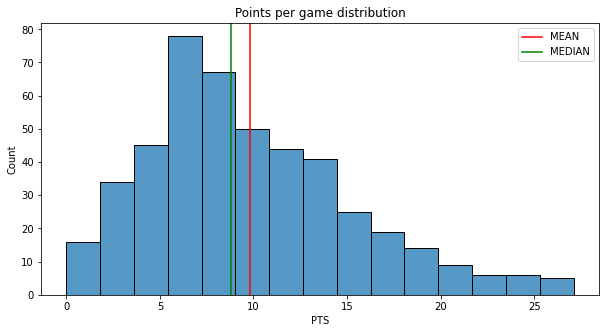

In [10]:
sns.histplot(data=data.PTS)
plt.title("Points per game distribution")
plt.axvline(data.PTS.mean(),color='red', label="MEAN")
plt.axvline(data.PTS.median(),color='green', label="MEDIAN")
plt.legend()
plt.show()

In [11]:
X= data.PTS
y=data.Salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test = scaler.transform(np.array(X_test).reshape(-1, 1))

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [12]:
model = SGDRegressor(random_state=42)
model.fit(X_train,y_train)
y_predict_sdg_unit_feature_model= model.predict(X_test)
default_mae=round(mean_absolute_error(y_test,y_predict_sdg_unit_feature_model))
print('Mean absolute error of SGD Regressor Model with one feature:',default_mae)

Mean absolute error of SGD Regressor Model with one feature: 4661663


1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [13]:
def search_best_hyperparameters(max_iter, eta0):
    '''
    This function searchs the best model hyperparameters (max_iter and eta0) based on Mean Absolute Error.
    Display the result in a dict.
    '''
    mae_list=[]
    hyp_max_iter_list=[]
    hyp_eta0_list=[]
    for hyp_max_iter in max_iter:
        for hyp_eta0 in eta0:
            model = SGDRegressor(max_iter=hyp_max_iter,eta0=hyp_eta0,random_state=42)
            model.fit(X_train,y_train)
            y_predict_sdg_unit_feature_model_hyp= model.predict(X_test)
            mae=round(mean_absolute_error(y_test,y_predict_sdg_unit_feature_model_hyp))
            mae_list.append(mae)
            hyp_max_iter_list.append(hyp_max_iter)
            hyp_eta0_list.append(hyp_eta0)
            

    array_mae=np.array(mae_list)

    
    result = {
        "hyperparameters": {"max_iter": hyp_max_iter_list[np.argmin(array_mae)], 
                            "eta0": hyp_eta0_list[np.argmin(array_mae)]}, 
        "mae": array_mae.min()
    }
    return result

In [14]:
# Example list of hyperparameters values
max_iter = [100,500,1000,5000,10000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
best_mae=result['mae']
print(result)

{'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001}, 'mae': 4550421}


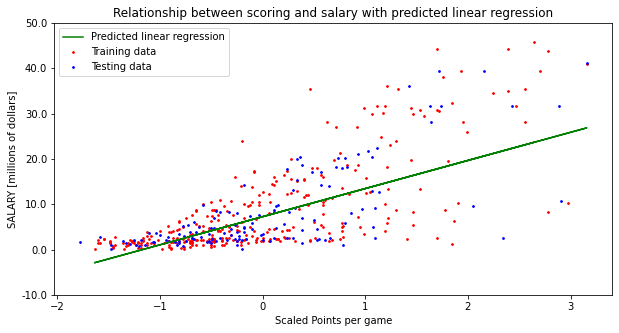

In [15]:
model=SGDRegressor(max_iter=result['hyperparameters']['max_iter'],eta0=result['hyperparameters']['eta0'],
                   random_state=42)
model.fit(X_train,y_train)
plt.scatter(X_train, y_train, label='Training data', c='r',s=3)
plt.scatter(X_test, y_test,label='Testing data', c='b', s=3)
plt.plot(X_train, model.predict(X_train), label='Predicted linear regression', c='g')

plt.yticks(graph.get_yticks(), graph.get_yticks() / 1000000)
plt.ylabel('SALARY [millions of dollars]')
plt.xlabel('Scaled Points per game')
plt.title("Relationship between scoring and salary with predicted linear regression")
plt.legend()
plt.show()

1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [16]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")

Mean Absolute Error for each model:
Baseline: 6905402
Default SGDRegressor: 4661663
Best SGDRegressor: 4550421


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [17]:
work_df=data.copy()
work_df=work_df[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER","TEAM_NAME","Salary"]]
work_df

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,Salary
0,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280
1,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171
2,13.2,8.2,3.5,0.9,4,Center,14,Heat,28103550
3,3.3,2.4,0.5,0.3,0,Forward,30,Grizzlies,1994520
4,19.1,8.1,1.9,1.1,15,Center,2,Nets,2641691
...,...,...,...,...,...,...,...,...,...
455,12.9,5.9,1.8,0.4,14,Forward,12,Raptors,14190000
456,25.0,3.9,9.0,0.2,3,Guard,5,Hawks,8326471
457,6.0,5.7,1.0,0.4,0,Center,Undrafted,Heat,1489065
458,8.5,6.0,1.4,0.6,9,Forward,4,Hornets,2389641


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [18]:
work_df['DRAFT_NUMBER']=work_df['DRAFT_NUMBER'].replace('Undrafted',np.nan).astype(float).astype('Int64')
work_df['DRAFT']=pd.cut(x=work_df['DRAFT_NUMBER'], bins=[0, 15, 30, 60],
       labels=['firstround_lottery','firstround_non_lottery','second_round'])
work_df['DRAFT']=work_df.DRAFT.astype('str').replace(np.NaN,'Undrafted')
work_df=work_df.drop('DRAFT_NUMBER', axis=1)
work_df

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,TEAM_NAME,Salary,DRAFT
0,6.5,5.1,0.8,0.5,1,Forward,Raptors,2711280,firstround_non_lottery
1,9.3,7.9,1.4,0.9,8,Center,Grizzlies,17073171,firstround_lottery
2,13.2,8.2,3.5,0.9,4,Center,Heat,28103550,firstround_lottery
3,3.3,2.4,0.5,0.3,0,Forward,Grizzlies,1994520,firstround_non_lottery
4,19.1,8.1,1.9,1.1,15,Center,Nets,2641691,firstround_lottery
...,...,...,...,...,...,...,...,...,...
455,12.9,5.9,1.8,0.4,14,Forward,Raptors,14190000,firstround_lottery
456,25.0,3.9,9.0,0.2,3,Guard,Hawks,8326471,firstround_lottery
457,6.0,5.7,1.0,0.4,0,Center,Heat,1489065,Undrafted
458,8.5,6.0,1.4,0.6,9,Forward,Hornets,2389641,firstround_lottery


1.12. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [19]:
df_dummies=pd.get_dummies(work_df[['DRAFT','POSITION','TEAM_NAME']])
work_df=pd.concat([work_df,df_dummies],axis=1)
work_df=work_df.drop(['DRAFT','POSITION','TEAM_NAME'], axis=1)
work_df

,PTS,REB,AST,BLK,SEASON_EXP,Salary,DRAFT_Undrafted,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
0,6.5,5.1,0.8,0.5,1,2711280,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,9.3,7.9,1.4,0.9,8,17073171,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.2,8.2,3.5,0.9,4,28103550,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.3,2.4,0.5,0.3,0,1994520,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,19.1,8.1,1.9,1.1,15,2641691,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,12.9,5.9,1.8,0.4,14,14190000,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
456,25.0,3.9,9.0,0.2,3,8326471,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
457,6.0,5.7,1.0,0.4,0,1489065,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458,8.5,6.0,1.4,0.6,9,2389641,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

1.13. Split the dataset into train and test

In [20]:
X= work_df.drop(labels='Salary',axis=1)
y= work_df.Salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [21]:
X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]]= scaler.fit_transform(
                                                    X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]]
                                                    )
X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]]= scaler.transform(
                                                    X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]]
                                                    )

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [22]:
#model with default hyperparameters
model = SGDRegressor(random_state=42)
model.fit(X_train,y_train)
y_predict_sdg_multiple_feature_model= model.predict(X_test)
default_mae_multiple_features=round(mean_absolute_error(y_test,y_predict_sdg_multiple_feature_model))
print('Mean absolute error of SGD Regressor Model with one feature:',default_mae_multiple_features)

Mean absolute error of SGD Regressor Model with one feature: 4935712


In [23]:
def search_best_hyperparameters_2(max_iter, eta0,alpha,penalty):
    '''
    This function searchs the best model hyperparameters (max_iter, eta0, alpha and penalty) based on
    Mean Absolute Error.
    Display the result in a dict.
    '''
    mae_list=[]
    hyp_max_iter_list=[]
    hyp_eta0_list=[]
    hyp_alpha_list=[]
    hyp_penalty_list=[]
    for hyp_max_iter in max_iter:
        for hyp_eta0 in eta0:
            for hyp_alpha in alpha:
                for hyp_penalty in penalty:
                    model = SGDRegressor(max_iter=hyp_max_iter,eta0=hyp_eta0,alpha=hyp_alpha,penalty=hyp_penalty
                                         ,random_state=42)
                    model.fit(X_train,y_train)
                    y_predict_sdg_multiple_feature_model_hyp= model.predict(X_test)
                    mae=round(mean_absolute_error(y_test,y_predict_sdg_multiple_feature_model_hyp))
                    mae_list.append(mae)
                    hyp_max_iter_list.append(hyp_max_iter)
                    hyp_eta0_list.append(hyp_eta0)
                    hyp_alpha_list.append(hyp_alpha)
                    hyp_penalty_list.append(hyp_penalty)
                    
    array_mae=np.array(mae_list)

    
    result = {
        "hyperparameters": {"max_iter": hyp_max_iter_list[np.argmin(array_mae)], 
                            "eta0": hyp_eta0_list[np.argmin(array_mae)],
                            "alpha": hyp_alpha_list[np.argmin(array_mae)],
                           "penalty": hyp_penalty_list[np.argmin(array_mae)]}, 
        "mae": array_mae.min()
    }
    return result

In [24]:
# Example list of hyperparameters values
max_iter = [100,500,1000,5000,10000]
eta0 = [0.0001, 0.001, 0.01, 0.1,0.5]
penalty=['l2','l1','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1,0.5]

result = search_best_hyperparameters_2(max_iter,eta0,alphas,penalty)
best_mae_multiple_features=result['mae']


In [25]:
print(result)

{'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001, 'alpha': 0.5, 'penalty': 'l2'}, 'mae': 4606594}


1.16. How did the model performed compared to our univariate models? 

In [26]:
print(f"Default SGDRegressor one feature: {default_mae}")
print(f"Best SGDRegressor one feature: {best_mae}")
print(f"Default SGDRegressor multiple feature: {default_mae_multiple_features}")
print(f"Best SGDRegressor mulltiple feature: {best_mae_multiple_features}")

Default SGDRegressor one feature: 4661663
Best SGDRegressor one feature: 4550421
Default SGDRegressor multiple feature: 4935712
Best SGDRegressor mulltiple feature: 4606594


In this case the sgd regressor with multiple features is slightly worst than the univariate model. I think it's because the complexity of this model isnt enough to solve this multi-feature problem. Maybe more feature can confuse the model. However we can see that the search of hyperparameters improves the error, in both cases. 

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [27]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train,y_train)
y_predict_DecisionTreeRegressor_model= model.predict(X_test)
default_mae_DecisionTreeRegressor=round(mean_absolute_error(y_test,y_predict_DecisionTreeRegressor_model))
print('Mean absolute error of DecisionTreeRegressor Model with default parameter:',default_mae_DecisionTreeRegressor)

Mean absolute error of DecisionTreeRegressor Model with default parameter: 4433805


In [28]:
def search_best_hyperparameters_decision_tree(max_depth, min_samples_leaf,max_features,X_train,y_train,X_test,y_test):
    '''
    This function searchs the best model hyperparameters (max_depth, min_samples_leaf,max_features) based on
    Mean Absolute Error.
    Display the result in a dict.
    '''
    mae_list=[]
    hyp_max_depth_list=[]
    hyp_min_samples_leaf_list=[]
    hyp_max_features_list=[]
    for hyp_max_depth in max_depth:
        for hyp_min_samples_leaf in min_samples_leaf:
            for hyp_max_features in max_features:
                model = DecisionTreeRegressor(max_depth=hyp_max_depth,min_samples_leaf=hyp_min_samples_leaf,
                                              max_features=hyp_max_features,random_state=42)
                model.fit(X_train,y_train)
                y_predict_decision_tree_model_hyp= model.predict(X_test)
                mae=round(mean_absolute_error(y_test,y_predict_decision_tree_model_hyp))
                mae_list.append(mae)
                
                hyp_max_depth_list.append(hyp_max_depth)
                hyp_min_samples_leaf_list.append(hyp_min_samples_leaf)
                hyp_max_features_list.append(hyp_max_features)

    array_mae=np.array(mae_list)

    
    result = {
        "hyperparameters": {"max_depth": hyp_max_depth_list[np.argmin(array_mae)], 
                            "min_samples_leaf": hyp_min_samples_leaf_list[np.argmin(array_mae)],
                            "max_features":hyp_max_features_list[np.argmin(array_mae)]
                           }, 
        "mae": array_mae.min()
    }
    return result

In [29]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50, None]
min_samples_leaf = [1, 2, 10, 20, 50]
max_features = [5, 10,'auto', 'sqrt', 'log2']

result = search_best_hyperparameters_decision_tree(max_depth, min_samples_leaf,max_features,X_train,y_train,X_test,
                                                   y_test)
best_mae_decision_tree=result['mae']
print(result)

{'hyperparameters': {'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 10}, 'mae': 3579341}


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [30]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor one feature: {default_mae}")
print(f"Best SGDRegressor one feature: {best_mae}")
print(f"Default SGDRegressor multiple feature: {default_mae_multiple_features}")
print(f"Best SGDRegressor mulltiple feature: {best_mae_multiple_features}")
print(f"Default DecisionTreeRegressor multiple feature: {default_mae_DecisionTreeRegressor}")
print(f"Best DecisionTreeRegressor mulltiple feature: {best_mae_decision_tree}")

Mean Absolute Error for each model:
Baseline: 6905402
Default SGDRegressor one feature: 4661663
Best SGDRegressor one feature: 4550421
Default SGDRegressor multiple feature: 4935712
Best SGDRegressor mulltiple feature: 4606594
Default DecisionTreeRegressor multiple feature: 4433805
Best DecisionTreeRegressor mulltiple feature: 3579341


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

In this dataset, non linear models works better than linear models. I think one reasons is for the nature of data, roockie contracts don't depend on the statistics, and you can see from the graph that it's non linear problem. Also when you use a lot of features, that depend on social things, it wont always be logical and in linear models it can confuse that.  

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

Maybe we can choose some features to fit the model only that have more than 0.5 correlated with salary and not correlated with each other. Also we can try droping team name feature, the one hot encoding can confuse that. Other thing can be create more features (we dont use min feature for example), or search for new statistical features (some defensive features). Other way can be use polinomical regressor and see the number of degree that best fit with this data (always in the test set). And finally you can search for more data, maybe information of years before.

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [31]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)
all_nba_df

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,...,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,...,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15348,15348,2817,2,Paul Zipser,2017-18,2017,CHI,54,12,15.3,...,0.355,0.760,2.4,0.9,0.4,0.3,0.8,1.6,4.0,0
15349,15349,2818,1,Ante Zizic,2017-18,2017,CLE,32,2,6.7,...,0.731,0.724,1.9,0.2,0.1,0.4,0.3,0.9,3.7,0
15351,15351,2819,1,Jim Zoet,1982-83,1982,DET,7,0,4.3,...,0.200,0.000,1.1,0.1,0.1,0.4,0.6,1.3,0.3,0
15352,15352,2820,1,Ivica Zubac,2016-17,2016,LAL,38,11,16.0,...,0.536,0.653,4.2,0.8,0.4,0.9,0.8,1.7,7.5,0


In [32]:
print('Number of rows:',all_nba_df.shape[0],'\n')
print('Number of seasons:',len(all_nba_df.season.unique()),'\n')
print('Number of unique players:',len(all_nba_df.player_id.unique()),'\n')
print('Number of all-nba selections vs non selected:')
print('Non selected:',all_nba_df.all_nba.value_counts()[0])
print('All-nba selections:',all_nba_df.all_nba.value_counts()[1])

Number of rows: 14825 

Number of seasons: 39 

Number of unique players: 2718 

Number of all-nba selections vs non selected:
Non selected: 14329
All-nba selections: 496


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [33]:
X=all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc',
              'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
y=all_nba_df['all_nba']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [34]:
print('Target distribution in all dataset:',round(y.value_counts()[1]/y.value_counts()[0],3))
print('Target distribution in train dataset:',round(y_train.value_counts()[1]/y_train.value_counts()[0],3))
print('Target distribution in test dataset:',round(y_test.value_counts()[1]/y_test.value_counts()[0],3))

Target distribution in all dataset: 0.035
Target distribution in train dataset: 0.035
Target distribution in test dataset: 0.035


The target distribution is held constant when we use stratify parameter in train-test split.

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [35]:
y_test.value_counts()

0    2866
1      99
Name: all_nba, dtype: int64

### Accuracy formula: 
$$
Accuracy= \frac{TP+TN}{TP+FP+TN+FN}
$$
If always predict 0 the accuracy will be:
$$
Accuracy= \frac{0+2866}{0+0+2866+99}
$$

$$
Accuracy= 0.97 = 97\%
$$

In [36]:
#using most frequent class to predict
dummy_majority = DummyClassifier(strategy='most_frequent') 

dummy_majority.fit(X_train, y_train)
print('Accuracy of Dummy Classifier is: ', dummy_majority.score(X_test, y_test))


Accuracy of Dummy Classifier is:  0.966610455311973


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

When you have an imbalanced dataset, the accuracy is not the best metric to evaluate your model. In this case, you have to choose a F1 score to evaluate them.

"Precision is a measure of the probability of actual positive cases given the total positive predictions of a machine learning model.
Recall on the other hand is a measure of the probability of predicting positive out of the number of ground truth positive. 
The F1-score seeks to provide a balance between the two as most times, it’s difficult to decide on whether to go for a high precision or high recall."

https://medium.com/analytics-vidhya/handling-imbalanced-datasets-dccaded84045


2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [37]:
X_train_without_team_column=X_train.drop(labels='team',axis=1)
X_test_without_team_column=X_test.drop(labels='team',axis=1)

col_list= ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc','trb', 'ast', 'stl',
           'blk', 'tov', 'pf', 'pts']

X_train_without_team_column[col_list]=scaler.fit_transform(X_train_without_team_column)
X_test_without_team_column[col_list]=scaler.transform(X_test_without_team_column)

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [38]:
model = LogisticRegression(random_state=42)
model.fit(X_train_without_team_column,y_train)
y_predict_default_model= model.predict(X_test_without_team_column)

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [39]:
print(classification_report(y_test, y_predict_default_model))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2866
           1       0.78      0.57      0.65        99

    accuracy                           0.98      2965
   macro avg       0.88      0.78      0.82      2965
weighted avg       0.98      0.98      0.98      2965



The metric that we have to see are in the row of label 1. This ones are metrics about target 1. 

In [40]:
print('Other way to show the same:')
print('f1_score:',round(f1_score(y_test, y_predict_default_model),2))
print('precision:',round(precision_score(y_test, y_predict_default_model),2))
print('recall:',round(recall_score(y_test, y_predict_default_model),2))
print('accuracy:',round(accuracy_score(y_test, y_predict_default_model),2))


Other way to show the same:
f1_score: 0.65
precision: 0.78
recall: 0.57
accuracy: 0.98


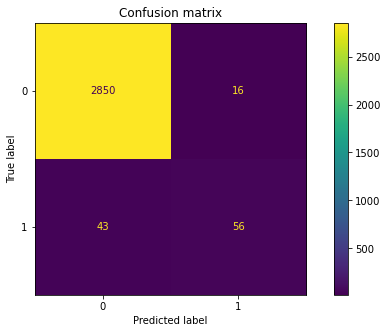

In [41]:
plot_confusion_matrix(model, X_test_without_team_column, y_test)
plt.title('Confusion matrix')
plt.show()

From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [42]:
df_dummies_train=pd.get_dummies(X_train['team'])
X_train=pd.concat([X_train_without_team_column,df_dummies_train],axis=1)

df_dummies_test=pd.get_dummies(X_test['team'])
X_test=pd.concat([X_test_without_team_column,df_dummies_test],axis=1)


#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [43]:
def search_best_hyperparameters_logistic_regression(tol, C,max_iter,X_train,y_train,X_test,y_test):
    '''
    This function searchs the best model hyperparameters (tol, C,max_iter) based on f1 score.
    Display the result in a dict.
    '''
    
    f1score_list=[]
    precision_list=[]
    recall_list=[]
    hyp_tol_list=[]
    hyp_C_list=[]
    hyp_max_iter_list=[]
    for hyp_tol in tol:
        for hyp_C in C:
            for hyp_max_iter in max_iter:
                model = LogisticRegression(tol=hyp_tol,C=hyp_C,
                                              max_iter=hyp_max_iter,random_state=42)
                model.fit(X_train,y_train)
                y_predict_logistic_regression_model_hyp= model.predict(X_test)
                
                f1score=f1_score(y_test,y_predict_logistic_regression_model_hyp)
                f1score_list.append(round(f1score,2))
                
                precision=precision_score(y_test,y_predict_logistic_regression_model_hyp)
                precision_list.append(round(precision,2))
                
                recall=recall_score(y_test,y_predict_logistic_regression_model_hyp)
                recall_list.append(round(recall,2))
                
                hyp_tol_list.append(hyp_tol)
                hyp_C_list.append(hyp_C)
                hyp_max_iter_list.append(hyp_max_iter)

    array_f1score=np.array(f1score_list)

    
    result = {
        "hyperparameters": {"tol": hyp_tol_list[np.argmax(array_f1score)], 
                            "C": hyp_C_list[np.argmax(array_f1score)],
                            "max_iter":hyp_max_iter_list[np.argmax(array_f1score)]
                           }, 
        "metrics":{"f1_score": array_f1score.max(),
                            "precision":precision_list[np.argmax(array_f1score)],
                            "recall":recall_list[np.argmax(array_f1score)]}
    }
    return result

In [44]:
tol=[0.0001,0.001,0.00001,0.01,0.1]
C=[1.0,0.1,0.01,10.0,100.0]
max_iter=[100,1000,10000,5000]

result = search_best_hyperparameters_logistic_regression(tol, C,max_iter,X_train,y_train,X_test,y_test)
print(result)

{'hyperparameters': {'tol': 0.1, 'C': 100.0, 'max_iter': 1000}, 'metrics': {'f1_score': 0.68, 'precision': 0.83, 'recall': 0.58}}


In [45]:
#Use the best hyperparameters to get the best model.
model = LogisticRegression(random_state=42,
                           tol=result['hyperparameters']['tol'],
                           C=result['hyperparameters']['C'],
                           max_iter=result['hyperparameters']['max_iter'])
model.fit(X_train,y_train)
y_predict_best_model= model.predict(X_test)
print(classification_report(y_test, y_predict_best_model))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2866
           1       0.83      0.58      0.68        99

    accuracy                           0.98      2965
   macro avg       0.91      0.79      0.83      2965
weighted avg       0.98      0.98      0.98      2965



In [46]:
print('Other way to show the same:')
print('f1_score:',round(f1_score(y_test, y_predict_best_model),2))
print('precision:',round(precision_score(y_test, y_predict_best_model),2))
print('recall:',round(recall_score(y_test, y_predict_best_model),2))
print('accuracy:',round(accuracy_score(y_test, y_predict_best_model),2))

Other way to show the same:
f1_score: 0.68
precision: 0.83
recall: 0.58
accuracy: 0.98


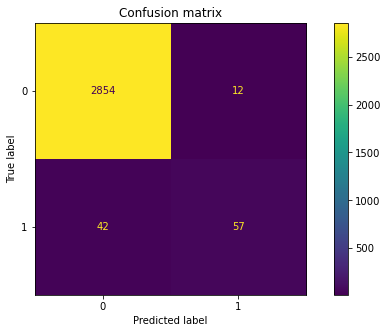

In [47]:
plot_confusion_matrix(model, X_test, y_test)
plt.title('Confusion matrix')
plt.show()

#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [48]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [49]:
all_nba_2018_df

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,34,5,2,Alex Abrines,2018-19,2018,OKC,31,2,19.0,...,0.323,0.500,0.923,1.5,0.6,0.5,0.2,0.5,1.7,5.3
49,49,8,7,Quincy Acy,2018-19,2018,PHO,10,0,12.3,...,0.133,0.667,0.700,2.5,0.8,0.1,0.4,0.4,2.4,1.7
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,34,1,12.6,...,0.338,0.361,0.778,1.8,1.9,0.4,0.1,0.8,1.3,3.2
71,71,13,6,Steven Adams,2018-19,2018,OKC,80,80,33.4,...,0.000,0.596,0.500,9.5,1.6,1.5,1.0,1.7,2.6,13.9
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,82,28,23.3,...,0.200,0.588,0.735,7.3,2.2,0.9,0.8,1.5,2.5,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,15319,2806,1,Trae Young,2018-19,2018,ATL,81,81,30.9,...,0.324,0.477,0.829,3.7,8.1,0.9,0.2,3.8,1.7,19.1
15333,15326,2808,6,Cody Zeller,2018-19,2018,CHO,49,47,25.4,...,0.273,0.570,0.787,6.8,2.1,0.8,0.8,1.3,3.3,10.1
15334,15334,2810,7,Tyler Zeller,2018-19,2018,TOT,6,1,15.5,...,0.000,0.552,0.778,4.0,0.7,0.2,0.5,0.7,3.3,7.7
15350,15350,2818,2,Ante Zizic,2018-19,2018,CLE,59,25,18.3,...,0.000,0.553,0.705,5.4,0.9,0.2,0.4,1.0,1.9,7.8


In [50]:
all_nba_2018_selections

,player_id,player,all_nba
34,5,Alex Abrines,0
49,8,Quincy Acy,0
70,10,Jaylen Adams,0
71,13,Steven Adams,0
79,15,Bam Adebayo,0
...,...,...,...
15319,2806,Trae Young,0
15333,2808,Cody Zeller,0
15334,2810,Tyler Zeller,0
15350,2818,Ante Zizic,0


In [51]:
#save this column name to later concatenate with the df.
player_names=all_nba_2018_df['player']


In [52]:
#scaling the numerical variables
all_nba_2018_df=all_nba_2018_df.drop(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start'], axis=1)
all_nba_2018_df[col_list]=scaler.transform(all_nba_2018_df[col_list])
all_nba_2018_df

,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,OKC,-0.928980,-0.816202,-0.136703,-0.864447,0.596239,0.417985,1.200117,-0.813199,-0.677860,-0.362958,-0.434056,-0.926134,-0.285790,-0.494559
49,PHO,-1.761780,-0.883638,-0.789927,-2.292930,-0.442336,2.097087,0.002548,-0.421585,-0.571225,-1.193255,-0.047068,-1.048590,0.532641,-1.092923
70,ATL,-0.810009,-0.849920,-0.760678,-0.991424,0.678231,-0.979591,0.421429,-0.695715,0.015267,-0.570532,-0.627549,-0.558765,-0.753465,-0.843605
71,OKC,1.014220,1.813816,1.267241,1.653914,-1.169338,1.383217,-1.071505,2.319708,-0.144686,1.712786,1.113894,0.543340,0.766478,0.934864
79,MIA,1.093534,0.060471,0.282530,1.452869,-0.076102,1.302781,0.190507,1.458159,0.175219,0.467340,0.726906,0.298427,0.649559,0.103804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,ATL,1.053877,1.847534,1.023500,-0.218985,0.601705,0.186731,0.695312,0.048351,3.320951,0.467340,-0.434056,3.114918,-0.285790,1.799167
15333,CHO,-0.215152,0.701116,0.487272,1.188335,0.322930,1.121800,0.469761,1.262352,0.121902,0.259766,0.726906,0.053515,1.584909,0.303258
15334,TOT,-1.920409,-0.849920,-0.477940,0.997871,-1.169338,0.940819,0.421429,0.165835,-0.624543,-0.985681,0.146425,-0.681222,1.584909,-0.095650
15350,CLE,0.181420,-0.040684,-0.204951,1.209498,-1.169338,0.950874,0.029399,0.714093,-0.517908,-0.985681,-0.047068,-0.313853,-0.051953,-0.079029


In [53]:
#Make one hot encoding of team name
df_dummies=pd.get_dummies(all_nba_2018_df['team'])
all_nba_2018_df=pd.concat([all_nba_2018_df,df_dummies],axis=1)
all_nba_2018_df=all_nba_2018_df.drop(['team'], axis=1)
all_nba_2018_df

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,ORL,PHI,PHO,POR,SAC,SAS,TOR,TOT,UTA,WAS
34,-0.928980,-0.816202,-0.136703,-0.864447,0.596239,0.417985,1.200117,-0.813199,-0.677860,-0.362958,...,0,0,0,0,0,0,0,0,0,0
49,-1.761780,-0.883638,-0.789927,-2.292930,-0.442336,2.097087,0.002548,-0.421585,-0.571225,-1.193255,...,0,0,1,0,0,0,0,0,0,0
70,-0.810009,-0.849920,-0.760678,-0.991424,0.678231,-0.979591,0.421429,-0.695715,0.015267,-0.570532,...,0,0,0,0,0,0,0,0,0,0
71,1.014220,1.813816,1.267241,1.653914,-1.169338,1.383217,-1.071505,2.319708,-0.144686,1.712786,...,0,0,0,0,0,0,0,0,0,0
79,1.093534,0.060471,0.282530,1.452869,-0.076102,1.302781,0.190507,1.458159,0.175219,0.467340,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,1.053877,1.847534,1.023500,-0.218985,0.601705,0.186731,0.695312,0.048351,3.320951,0.467340,...,0,0,0,0,0,0,0,0,0,0
15333,-0.215152,0.701116,0.487272,1.188335,0.322930,1.121800,0.469761,1.262352,0.121902,0.259766,...,0,0,0,0,0,0,0,0,0,0
15334,-1.920409,-0.849920,-0.477940,0.997871,-1.169338,0.940819,0.421429,0.165835,-0.624543,-0.985681,...,0,0,0,0,0,0,0,1,0,0
15350,0.181420,-0.040684,-0.204951,1.209498,-1.169338,0.950874,0.029399,0.714093,-0.517908,-0.985681,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Add the missing team names encoding 
missing_names=X_train.columns.difference(all_nba_2018_df.columns)
missing_df=pd.DataFrame(np.zeros((530,10),dtype='int8'),columns=missing_names)
all_nba_2018_df=pd.concat([all_nba_2018_df.reset_index(drop=True),missing_df],axis=1)
all_nba_2018_df

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,CHA,CHH,KCK,NJN,NOH,NOK,SDC,SEA,VAN,WSB
0,-0.928980,-0.816202,-0.136703,-0.864447,0.596239,0.417985,1.200117,-0.813199,-0.677860,-0.362958,...,0,0,0,0,0,0,0,0,0,0
1,-1.761780,-0.883638,-0.789927,-2.292930,-0.442336,2.097087,0.002548,-0.421585,-0.571225,-1.193255,...,0,0,0,0,0,0,0,0,0,0
2,-0.810009,-0.849920,-0.760678,-0.991424,0.678231,-0.979591,0.421429,-0.695715,0.015267,-0.570532,...,0,0,0,0,0,0,0,0,0,0
3,1.014220,1.813816,1.267241,1.653914,-1.169338,1.383217,-1.071505,2.319708,-0.144686,1.712786,...,0,0,0,0,0,0,0,0,0,0
4,1.093534,0.060471,0.282530,1.452869,-0.076102,1.302781,0.190507,1.458159,0.175219,0.467340,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1.053877,1.847534,1.023500,-0.218985,0.601705,0.186731,0.695312,0.048351,3.320951,0.467340,...,0,0,0,0,0,0,0,0,0,0
526,-0.215152,0.701116,0.487272,1.188335,0.322930,1.121800,0.469761,1.262352,0.121902,0.259766,...,0,0,0,0,0,0,0,0,0,0
527,-1.920409,-0.849920,-0.477940,0.997871,-1.169338,0.940819,0.421429,0.165835,-0.624543,-0.985681,...,0,0,0,0,0,0,0,0,0,0
528,0.181420,-0.040684,-0.204951,1.209498,-1.169338,0.950874,0.029399,0.714093,-0.517908,-0.985681,...,0,0,0,0,0,0,0,0,0,0


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [55]:
y_test_new_dataset=all_nba_2018_selections.all_nba

In [56]:
y_predict_new_dataset= model.predict(all_nba_2018_df)
print(classification_report(y_test_new_dataset, y_predict_new_dataset))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       515
           1       0.58      0.93      0.72        15

    accuracy                           0.98       530
   macro avg       0.79      0.96      0.85       530
weighted avg       0.99      0.98      0.98       530



In [57]:
print('Other way to show the same:')
print('f1_score:',round(f1_score(y_test_new_dataset, y_predict_new_dataset),2))
print('precision:',round(precision_score(y_test_new_dataset, y_predict_new_dataset),2))
print('recall:',round(recall_score(y_test_new_dataset, y_predict_new_dataset),2))
print('accuracy:',round(accuracy_score(y_test_new_dataset, y_predict_new_dataset),2))

Other way to show the same:
f1_score: 0.72
precision: 0.58
recall: 0.93
accuracy: 0.98


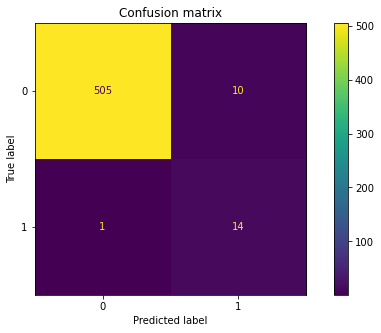

In [58]:
plot_confusion_matrix(model, all_nba_2018_df, y_test_new_dataset)
plt.title('Confusion matrix')
plt.show()

2.12. Analyze the results, what do you think it is happening?

What its happening is that the recall now is greater than the precision. If we see at the confusion matrix we correctly predict  almost all the people who were selected. However the precision now is poor because we say that more people were selected but they weren't. The f1 score doesnt change so much, so the precision and recall trade-off is still the same. 

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [59]:
#show the probabilities and player name to the original df
X_test=all_nba_2018_df.copy()
all_nba_2018_df['probabilities']=model.predict_proba(X_test)[:,1].round(3)
all_nba_2018_df=pd.concat([all_nba_2018_df,player_names.reset_index(drop=True)],axis=1)
all_nba_2018_df


,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,KCK,NJN,NOH,NOK,SDC,SEA,VAN,WSB,probabilities,player
0,-0.928980,-0.816202,-0.136703,-0.864447,0.596239,0.417985,1.200117,-0.813199,-0.677860,-0.362958,...,0,0,0,0,0,0,0,0,0.000,Alex Abrines
1,-1.761780,-0.883638,-0.789927,-2.292930,-0.442336,2.097087,0.002548,-0.421585,-0.571225,-1.193255,...,0,0,0,0,0,0,0,0,0.000,Quincy Acy
2,-0.810009,-0.849920,-0.760678,-0.991424,0.678231,-0.979591,0.421429,-0.695715,0.015267,-0.570532,...,0,0,0,0,0,0,0,0,0.000,Jaylen Adams
3,1.014220,1.813816,1.267241,1.653914,-1.169338,1.383217,-1.071505,2.319708,-0.144686,1.712786,...,0,0,0,0,0,0,0,0,0.013,Steven Adams
4,1.093534,0.060471,0.282530,1.452869,-0.076102,1.302781,0.190507,1.458159,0.175219,0.467340,...,0,0,0,0,0,0,0,0,0.000,Bam Adebayo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1.053877,1.847534,1.023500,-0.218985,0.601705,0.186731,0.695312,0.048351,3.320951,0.467340,...,0,0,0,0,0,0,0,0,0.112,Trae Young
526,-0.215152,0.701116,0.487272,1.188335,0.322930,1.121800,0.469761,1.262352,0.121902,0.259766,...,0,0,0,0,0,0,0,0,0.000,Cody Zeller
527,-1.920409,-0.849920,-0.477940,0.997871,-1.169338,0.940819,0.421429,0.165835,-0.624543,-0.985681,...,0,0,0,0,0,0,0,0,0.000,Tyler Zeller
528,0.181420,-0.040684,-0.204951,1.209498,-1.169338,0.950874,0.029399,0.714093,-0.517908,-0.985681,...,0,0,0,0,0,0,0,0,0.000,Ante Zizic


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [60]:
#show the higher probabilities to have been selected
best_15_players=all_nba_2018_df.sort_values('probabilities',ascending=False).head(15)
best_15_players

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,KCK,NJN,NOH,NOK,SDC,SEA,VAN,WSB,probabilities,player
17,0.696963,1.544071,1.208743,1.474031,0.230005,1.835670,0.158286,3.494548,2.147967,1.297637,...,0,0,0,0,0,0,0,0,1.000,Giannis Antetokounmpo
205,0.934905,1.746380,1.598727,0.034968,0.842217,0.699511,0.963825,1.184029,3.001046,2.750658,...,0,0,0,0,0,0,0,0,1.000,James Harden
125,0.062448,1.004580,1.228242,0.828569,0.639968,0.890547,0.507353,3.298742,1.081617,1.920361,...,0,0,0,0,0,0,0,0,0.999,Anthony Davis
257,0.022791,0.970862,1.442733,0.754499,0.683698,1.242454,-0.185411,1.928095,3.427586,1.297637,...,0,0,0,0,0,0,0,0,0.999,LeBron James
154,0.379705,1.274325,1.296489,0.479384,0.470517,0.769893,0.561056,3.925323,0.974982,0.052191,...,0,0,0,0,0,0,0,0,0.992,Joel Embiid
300,0.221077,1.139453,1.325738,0.606361,0.858615,0.840274,0.829569,1.458159,0.761712,2.335509,...,0,0,0,0,0,0,0,0,0.979,Kawhi Leonard
491,1.014220,1.813816,1.072248,0.839150,0.820352,0.910656,0.480502,3.298742,1.028299,0.674914,...,0,0,0,0,0,0,0,0,0.974,Nikola Vucevic
479,0.895248,1.712662,1.237992,0.839150,1.017135,1.041364,0.732904,3.455387,0.815029,0.467340,...,0,0,0,0,0,0,0,0,0.939,Karl-Anthony Towns
505,0.736620,1.577789,1.520730,-0.113171,0.415855,0.226949,-0.233744,2.946290,4.707206,2.543084,...,0,0,0,0,0,0,0,0,0.933,Russell Westbrook
268,1.014220,1.813816,1.062499,0.765081,0.508780,1.111746,0.652350,2.828806,2.894411,1.505212,...,0,0,0,0,0,0,0,0,0.921,Nikola Jokic


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [61]:
prediction=set(best_15_players.player)
reality=set(all_nba_2018_selections[all_nba_2018_selections.all_nba == 1].player)

In [62]:
print('Players actually selected from the all_nba_2018_selections dataset\n')
print(all_nba_2018_selections[all_nba_2018_selections.all_nba == 1].player,'\n')

print('Players actually selected missing from OUR predictions')
print(reality.difference(prediction),'\n')

print('Players in our predictions not selected')
print(prediction.difference(reality),'\n')

print('Players actually selected correctly from our predictions')
print(prediction.intersection(reality))

Players actually selected from the all_nba_2018_selections dataset

453      Giannis Antetokounmpo
3168             Stephen Curry
3908              Kevin Durant
4145               Joel Embiid
4895               Paul George
5016               Rudy Gobert
5399             Blake Griffin
5604              James Harden
6634              Kyrie Irving
6857              LeBron James
7225              Nikola Jokic
8103             Kawhi Leonard
8206            Damian Lillard
14132             Kemba Walker
14479        Russell Westbrook
Name: player, dtype: object 

Players actually selected missing from OUR predictions
{'Paul George', 'Kyrie Irving', 'Blake Griffin', 'Damian Lillard', 'Stephen Curry'} 

Players in our predictions not selected
{'Clint Capela', 'Anthony Davis', 'Karl-Anthony Towns', 'Nikola Vucevic', 'Jrue Holiday'} 

Players actually selected correctly from our predictions
{'Nikola Jokic', 'Kemba Walker', 'Kevin Durant', 'LeBron James', 'Giannis Antetokounmpo', 'Kawhi Leonard', 

2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [63]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        self.probabilities=None
        self.index_max_probabilities=None
        self.results=None
        
    def predict(self,X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """
        self.probabilities=self._model.predict_proba(X)[:,1].round(2)
        self.index_max_probabilities=self.probabilities.argsort()[-15:]
        self.results=np.zeros(len(X))
        self.results[self.index_max_probabilities]=1
        
        return self.results

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [64]:
all_nba_fitted_model=AllNbaSingleSeasonClassifier(model)

In [65]:
y_predict_best_probabilities=all_nba_fitted_model.predict(X_test)

In [66]:
print(classification_report(y_test_new_dataset, y_predict_best_probabilities))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       515
           1       0.67      0.67      0.67        15

    accuracy                           0.98       530
   macro avg       0.83      0.83      0.83       530
weighted avg       0.98      0.98      0.98       530



In [67]:
print('Other way to show the same:')
print('f1_score:',round(f1_score(y_test_new_dataset, y_predict_best_probabilities),2))
print('precision:',round(precision_score(y_test_new_dataset, y_predict_best_probabilities),2))
print('recall:',round(recall_score(y_test_new_dataset, y_predict_best_probabilities),2))
print('accuracy:',round(accuracy_score(y_test_new_dataset, y_predict_best_probabilities),2))

Other way to show the same:
f1_score: 0.67
precision: 0.67
recall: 0.67
accuracy: 0.98


Confusion matrix


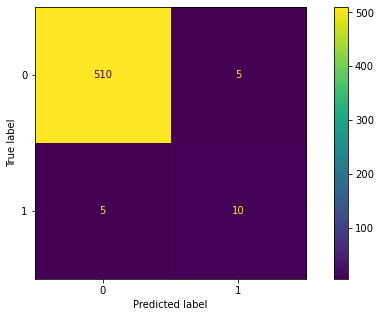

In [68]:
print('Confusion matrix')
cm=confusion_matrix(y_test_new_dataset, y_predict_best_probabilities)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

I think the main problem in this dataset is the imbalance of the classes. The model sees class 0 more times the  so it fits its weights more times trying to predict this class. But this class isnt our priority. So maybe balancing the data the model will perform more efficiently.

2.19. What do you think we could do to improve our model?

The best way to solve this imbalance problem, is to oversample the minority class. Thus, the model can adjust its weights to better predict both classes. Another thing it could be change the model to another one more accurate like decision tree, random forest or a deep learning model. With these complex models the performance could be better.

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

In [69]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_train, y_train)


In [70]:
print('Target distribution before resample')
y_train.value_counts()

Target distribution before resample


0    11463
1      397
Name: all_nba, dtype: int64

In [71]:
print('Target distribution after resample')
y_res.value_counts()

Target distribution after resample


0    11463
1    11463
Name: all_nba, dtype: int64

In [72]:
#searching best hyperparameters for the new data
tol=[0.0001,0.001,0.00001,0.01,0.1]
C=[1.0,0.1,0.01,10.0,100.0]
max_iter=[100,1000,10000,5000]

result = search_best_hyperparameters_logistic_regression(tol, C,max_iter,X_res,y_res,X_test,y_test_new_dataset)
print(result)

{'hyperparameters': {'tol': 0.0001, 'C': 100.0, 'max_iter': 1000}, 'metrics': {'f1_score': 0.6, 'precision': 0.43, 'recall': 1.0}}


In [73]:
#Use the best hyperparameters to get the best model.
model = LogisticRegression(random_state=42,
                           tol=result['hyperparameters']['tol'],
                           C=result['hyperparameters']['C'],
                           max_iter=result['hyperparameters']['max_iter'])
model.fit(X_res,y_res)
y_predict_res= model.predict(X_test)
print(classification_report(y_test_new_dataset, y_predict_res))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       515
           1       0.43      1.00      0.60        15

    accuracy                           0.96       530
   macro avg       0.71      0.98      0.79       530
weighted avg       0.98      0.96      0.97       530



In [74]:
print('Other way to show the same:')
print('f1_score:',round(f1_score(y_test_new_dataset, y_predict_res),2))
print('precision:',round(precision_score(y_test_new_dataset, y_predict_res),2))
print('recall:',round(recall_score(y_test_new_dataset, y_predict_res),2))
print('accuracy:',round(accuracy_score(y_test_new_dataset, y_predict_res),2))

Other way to show the same:
f1_score: 0.6
precision: 0.43
recall: 1.0
accuracy: 0.96


Confusion matrix


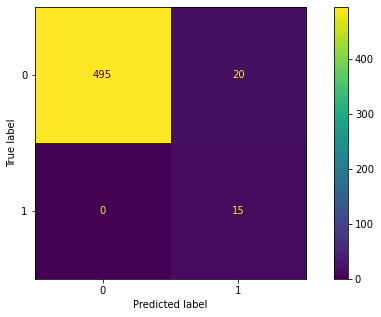

In [75]:
print('Confusion matrix')
cm=confusion_matrix(y_test_new_dataset, y_predict_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

We dont see the performance to be better than before resampling. Maybe smote is not the best way to create data, because it isnt creating real data.

## Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [76]:
    
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
    
    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor
        
        Parameters
        ----------
        epochs: int
            number of epochs to run gradient descent
        learning_rate: float
            rate of update of the gradients
        """
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.weights = None
        self.bias = None
        

    def _gradient_descent(self,X,y):
        """
        Gradient descent algorithm
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
        # perform gradient descent for n epochs
        for i in range(self.epochs):
            # get y_prediction
            y_pred = self.predict(X)
            error = y_pred - y
            
            # compute the gradients of weight and bias
            gradient_weights = (1 / self.n_samples) * np.dot(X.T, error)
            gradient_bias = (1 / self.n_samples) * np.sum(error)
            
            # update weights and bias with gradients
            self.weights -= self.learning_rate * gradient_weights
            self.bias -= self.learning_rate * gradient_bias
        

    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
        # get number of samples and features
        self.n_samples, self.n_features = X.shape
        # init weights and bias randomly
        self.weights = np.random.rand(self.n_features)
        self.bias = np.random.rand(1)
        # perform gradient descent
        self._gradient_descent(X,y)
             
    def predict(self, X):
        """
        Predict
        
        Parameters
        ----------
        X: np.ndarray
        
        Returns
        -------
        np.ndarray
            array with predictions
        """
        y_pred = np.dot(X, self.weights) + self.bias
        return y_pred

3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

In [77]:
X= data.PTS
y=data.Salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test = scaler.transform(np.array(X_test).reshape(-1, 1))

In [78]:
def search_best_hyperparameters_customized_linreg(epochs, learning_rate):
    '''
    This function searchs the best model hyperparameters (epochs, learning_rate) based on Mean Absolute Error of the
    customized linear regresion.
    Display the result in a dict.
    '''
    
    
    mae_list=[]
    hyp_epochs_list=[]
    hyp_learning_rate_list=[]
    for hyp_epochs in epochs:
        for hyp_learning_rate in learning_rate:
            model = LinearRegressor(epochs=hyp_epochs,learning_rate=hyp_learning_rate)
            model.fit(X_train,y_train)
            y_predict_customized_linreg= model.predict(X_test)
            mae=round(mean_absolute_error(y_test,y_predict_customized_linreg))
            mae_list.append(mae)
            hyp_epochs_list.append(hyp_epochs)
            hyp_learning_rate_list.append(hyp_learning_rate)
            

    array_mae=np.array(mae_list)

    
    result = {
        "hyperparameters": {"epochs": hyp_epochs_list[np.argmin(array_mae)], 
                            "learning_rate": hyp_learning_rate_list[np.argmin(array_mae)]}, 
        "mae": array_mae.min()
    }
    return result

In [79]:
epochs = [5,10,100,500,1000,5000]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.5]

result = search_best_hyperparameters_customized_linreg(epochs, learning_rate)

print(result)

{'hyperparameters': {'epochs': 5, 'learning_rate': 0.5}, 'mae': 4625452}


In [80]:
linreg = LinearRegressor(learning_rate=result['hyperparameters']['learning_rate'], 
                         epochs=result['hyperparameters']['epochs'])
linreg.fit(X_train, y_train)


3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.

In [81]:
# make prediction
y_predict = linreg.predict(X_test)
mae_customized_linear_regressor=round(mean_absolute_error(y_test,y_predict))
print("Mean Absolute Error for each model:")
print(f"Best SGDRegressor from sklearn: {best_mae}")
print(f"Best customized Linear Regressor: {mae_customized_linear_regressor}")


Mean Absolute Error for each model:
Best SGDRegressor from sklearn: 4550421
Best customized Linear Regressor: 4625452
